Load necessary libraries.

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from statistics import mean
from matplotlib import pyplot as plt

# I. Model Testing on All Data

Create explanatory and response variables.

In [2]:
df = pd.read_csv('train.csv')
X = df.drop(['outcome'], axis=1)
y = pd.get_dummies(df['outcome'], drop_first=True)

Identify numeric and categorical columns.

In [3]:
numeric_columns = X.select_dtypes(include=['number']).columns

categorical_columns = list(set(X.columns) - set(numeric_columns))

Preprocess data. Need column names for importance so do transformations seperately and join dfs after.

In [4]:
numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
categorical_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('ohe', OneHotEncoder(sparse=False))])

num_X = pd.DataFrame(numeric_pipe.fit_transform(X[numeric_columns]), columns=numeric_columns)

cat_X = categorical_pipe.fit_transform(X[categorical_columns])
onehot_col_names = categorical_pipe.named_steps['ohe'].get_feature_names_out(input_features=categorical_columns)
cat_X = pd.DataFrame(cat_X, columns=onehot_col_names)

X = pd.merge(num_X, cat_X, left_index=True, right_index=True)

y = np.ravel(y).reshape((-1,))

X.head()

,r_kd,r_sub.att,r_rev.,r_ctrl_s,r_sig_str_percent,r_sig_str_att,r_total_str_percent,r_total_str_att,r_td_percent,r_td_att,...,weightclass_Light Heavyweight,weightclass_Lightweight,weightclass_Middleweight,weightclass_Welterweight,weightclass_Women's Bantamweight Bout,weightclass_Women's Featherweight,weightclass_Women's Flyweight Bout,weightclass_Women's Strawweight,title_False,title_True
0,0.222222,0.222222,0.000000,100.444444,0.410538,202.444444,0.431990,213.611111,0.642857,1.555556,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.166667,0.000000,0.000000,195.666667,0.426600,132.833333,0.514486,166.833333,0.280000,4.166667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.571429,0.285714,0.214286,132.500000,0.502677,106.714286,0.545293,120.642857,0.500000,2.714286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.333333,0.222222,0.111111,123.111111,0.390576,106.111111,0.497585,138.000000,0.428571,0.777778,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.000000,0.000000,0.000000,47.000000,0.693878,49.000000,0.716981,53.000000,0.250000,4.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# XGBoost

## Randomized Search
Tune model parameters and obtain cv accuracy estimates.

In [5]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(random_state=1, n_jobs=-1)
distributions1 = dict(learning_rate = [0.05, 0.1, 0.15],
                      n_estimators = [50, 100, 150],
                      max_depth = range(2,10),
                      min_child_weight = range(1,10))
random1 = RandomizedSearchCV(estimator=clf, param_distributions=distributions1,
                            scoring='neg_log_loss', n_iter=10, cv=rkf, random_state=1) # TODO Does changing the seed here only change the parameter grid? If so can I change it to obtain better results? Yes
random1.fit(X, y)
print("Highest neg_log_loss: ", random1.best_score_)
print("Best parameters: ", random1.best_params_)

Highest negative log_loss:  -0.5610222536652344
Best parameters:  {'n_estimators': 50, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.15}


In [6]:
random_table1 = pd.concat([pd.DataFrame(random1.cv_results_["params"]),
                          pd.DataFrame(random1.cv_results_["mean_test_score"],
                                       columns=["Negative Log Loss"])],axis=1)
random_table1.sort_values("Negative Log Loss", ascending=False)

,n_estimators,min_child_weight,max_depth,learning_rate,Negative Log Loss
4,50,6,3,0.15,-0.561022
2,50,3,3,0.15,-0.561252
0,150,3,2,0.15,-0.561417
8,150,3,6,0.05,-0.561452
1,150,9,2,0.10,-0.561550
6,100,9,9,0.05,-0.562938
5,150,2,3,0.15,-0.566242
3,150,8,6,0.10,-0.574673
9,50,5,9,0.15,-0.578315
7,150,1,8,0.10,-0.595246


Recalibrate n_estimators

In [11]:
xgb_param = XGBClassifier(learning_rate=0.15, max_depth=3, min_child_weight=6, random_state=1, n_jobs=-1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

63
0     0.667364
1     0.647476
2     0.632641
3     0.621181
4     0.611558
        ...   
58    0.560287
59    0.560191
60    0.560021
61    0.560022
62    0.559889
Name: test-logloss-mean, Length: 63, dtype: float64


In [12]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.15, n_estimators=63, max_depth=3, min_child_weight=6, random_state=1, n_jobs=-1)
distributions2 = dict(gamma=np.arange(0,1.1,0.2),
                      subsample = np.arange(0.5, 1.0, 0.1),
                      colsample_bytree = np.arange(0.4, 1.0, 0.1),
                      reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],
                      reg_lambda=[1e-5, 1e-2, 0.1, 1, 100])
random2 = RandomizedSearchCV(estimator=clf, param_distributions=distributions2,
                            scoring='neg_log_loss', n_iter=10, cv=rkf, random_state=33)
random2.fit(X, y)
print("Highest neg_log_loss: ", random2.best_score_)
print("Best parameters: ", random2.best_params_)

Highest neg_log_loss:  -0.5611736740420186
Best parameters:  {'subsample': 0.8999999999999999, 'reg_lambda': 1, 'reg_alpha': 0.01, 'gamma': 0.8, 'colsample_bytree': 0.6}


In [13]:
random_table2 = pd.concat([pd.DataFrame(random2.cv_results_["params"]),
                          pd.DataFrame(random2.cv_results_["mean_test_score"],
                                       columns=["Negative Log Loss"])],axis=1)
random_table2.sort_values("Negative Log Loss", ascending=False)

,subsample,reg_lambda,reg_alpha,gamma,colsample_bytree,Negative Log Loss
9,0.9,1.00000,0.01000,0.8,0.6,-0.561174
0,0.9,0.10000,0.10000,0.2,0.7,-0.561336
1,0.8,0.00001,1.00000,0.8,0.4,-0.561991
4,0.7,0.01000,0.10000,0.0,0.4,-0.563341
2,0.6,0.01000,1.00000,0.6,0.7,-0.564201
3,0.8,100.00000,0.00001,0.4,0.8,-0.565334
7,0.9,0.01000,100.00000,0.8,0.6,-0.590562
5,0.8,1.00000,100.00000,1.0,0.6,-0.594931
6,0.7,0.00001,100.00000,0.0,0.4,-0.598880
8,0.7,100.00000,100.00000,0.2,0.6,-0.600046


## Regular Grid Search
Tune model parameters and obtain cv accuracy estimates.

For learning rates, determine the optimum n_estimators, and corresponding accuracy.

In [15]:
for i in np.arange(0.05, 0.35, 0.05):
    xgb_param = XGBClassifier(learning_rate=i, random_state=1).get_xgb_params()
    xg = xgb.DMatrix(X.values, label=y)
    cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                      metrics='logloss', early_stopping_rounds=100, seed=1)
    print(cvresult.shape[0])
    print(cvresult['test-logloss-mean'])

104
0      0.683219
1      0.674360
2      0.666257
3      0.658706
4      0.652150
         ...   
99     0.558593
100    0.558510
101    0.558630
102    0.558515
103    0.558508
Name: test-logloss-mean, Length: 104, dtype: float64
46
0     0.673892
1     0.658654
2     0.645228
3     0.634244
4     0.625008
5     0.616943
6     0.610301
7     0.604548
8     0.599439
9     0.595171
10    0.590926
11    0.587384
12    0.583950
13    0.581350
14    0.578960
15    0.576352
16    0.574626
17    0.573122
18    0.571528
19    0.570151
20    0.568799
21    0.567751
22    0.566846
23    0.565865
24    0.565271
25    0.564632
26    0.564196
27    0.563558
28    0.563040
29    0.562812
30    0.562569
31    0.562203
32    0.561912
33    0.561738
34    0.561296
35    0.561236
36    0.560788
37    0.560707
38    0.560296
39    0.560188
40    0.560165
41    0.560014
42    0.560121
43    0.559779
44    0.559404
45    0.559265
Name: test-logloss-mean, dtype: float64
33
0     0.665165
1     0.644659
2

Tune max_depth and min_child_weight

In [16]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=104, random_state=1, n_jobs=-1)
param_grid1 = dict(max_depth=range(2,10,2),
                   min_child_weight=range(1,10,2))
grid1 = GridSearchCV(estimator=clf, param_grid=param_grid1, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid1.fit(X, y)
print("Highest neg_log_loss: ", grid1.best_score_)
print("Best parameters:", grid1.best_params_)

Highest neg_log_loss:  -0.5591411604289879
Best parameters: {'max_depth': 6, 'min_child_weight': 5}


In [17]:
grid1_table = pd.concat([pd.DataFrame(grid1.cv_results_['params']),
                         pd.DataFrame(grid1.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid1_table.sort_values('Negative Log Loss', ascending=False)

,max_depth,min_child_weight,Negative Log Loss
12,6,5,-0.559141
7,4,5,-0.559450
6,4,3,-0.559827
11,6,3,-0.559940
8,4,7,-0.559972
5,4,1,-0.560170
13,6,7,-0.560231
14,6,9,-0.560249
9,4,9,-0.560555
10,6,1,-0.560733


More fine tuning around optimal params from previous step

In [18]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=104, random_state=1, n_jobs=-1)
param_grid2 = dict(max_depth=[5,6,7],
                   min_child_weight=[4,5,6])
grid2 = GridSearchCV(estimator=clf, param_grid=param_grid2, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid2.fit(X, y)
print("Highest neg_log_loss: ", grid2.best_score_)
print("Best parameters:", grid2.best_params_)

Highest neg_log_loss:  -0.5590370359948695
Best parameters: {'max_depth': 5, 'min_child_weight': 5}


In [19]:
grid2_table = pd.concat([pd.DataFrame(grid2.cv_results_['params']),
                         pd.DataFrame(grid2.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid2_table.sort_values('Negative Log Loss', ascending=False)

,max_depth,min_child_weight,Negative Log Loss
1,5,5,-0.559037
2,5,6,-0.559073
4,6,5,-0.559141
0,5,4,-0.559241
5,6,6,-0.559439
3,6,4,-0.559517
8,7,6,-0.560571
7,7,5,-0.560805
6,7,4,-0.560990


Recalibrate n_estimators

In [20]:
xgb_param = XGBClassifier(learning_rate=0.05, max_depth=5, min_child_weight=5, random_state=1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

138
0      0.683435
1      0.674721
2      0.666776
3      0.659504
4      0.652919
         ...   
133    0.557573
134    0.557578
135    0.557572
136    0.557599
137    0.557544
Name: test-logloss-mean, Length: 138, dtype: float64


Tune gamma.

In [16]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=138, max_depth=5, min_child_weight=5, random_state=1, n_jobs=-1)
param_grid3 = dict(gamma=np.arange(0,1.2,0.2))
grid3 = GridSearchCV(estimator=clf, param_grid=param_grid3, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid3.fit(X, y)
print("Highest neg_log_loss: ", grid3.best_score_)
print("Best parameters:", grid3.best_params_)

Highest neg_log_loss:  -0.5588244634449913
Best parameters: {'gamma': 0.6000000000000001}


In [17]:
grid3_table = pd.concat([pd.DataFrame(grid3.cv_results_['params']),
                         pd.DataFrame(grid3.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid3_table.sort_values('Negative Log Loss', ascending=False)

,gamma,Negative Log Loss
3,0.6,-0.558824
4,0.8,-0.558845
0,0.0,-0.558960
2,0.4,-0.558963
5,1.0,-0.559053
1,0.2,-0.559083


Recalibrate n_estimators.

In [5]:
xgb_param = XGBClassifier(learning_rate=0.05, max_depth=5, min_child_weight=5, gamma=0.6, random_state=1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

113
0      0.683434
1      0.674721
2      0.666776
3      0.659504
4      0.652918
         ...   
108    0.558372
109    0.558314
110    0.558357
111    0.558158
112    0.558141
Name: test-logloss-mean, Length: 113, dtype: float64


Tune subsample and colsample_bytree.

In [7]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=113,  max_depth=5, min_child_weight=5, gamma=0.6, random_state=1, n_jobs=-1)
param_grid4 = dict(subsample=[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   colsample_bytree=[0.5, 0.6, 0.7, 0.8, 0.9, 1])
grid4 = GridSearchCV(estimator=clf, param_grid=param_grid4, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid4.fit(X, y)
print("Highest neg_log_loss: ", grid4.best_score_)
print("Best parameters:", grid4.best_params_)

Highest neg_log_loss:  -0.5585479271728603
Best parameters: {'colsample_bytree': 0.9, 'subsample': 1}


In [8]:
grid4_table = pd.concat([pd.DataFrame(grid4.cv_results_['params']),
                         pd.DataFrame(grid4.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid4_table.sort_values('Negative Log Loss', ascending=False)

,colsample_bytree,subsample,Negative Log Loss
29,0.9,1.0,-0.558548
28,0.9,0.9,-0.558566
16,0.7,0.9,-0.558607
35,1.0,1.0,-0.558638
22,0.8,0.9,-0.558789
34,1.0,0.9,-0.558848
23,0.8,1.0,-0.558903
33,1.0,0.8,-0.559263
27,0.9,0.8,-0.559378
15,0.7,0.8,-0.559478


Tune regularization parameters.

In [10]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=113, max_depth=5, min_child_weight=5, gamma=0.6,
                    colsample_bytree= 0.9, subsample = 1, random_state=1, n_jobs=-1)
param_grid5 = dict(reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],
                   reg_lambda=[1e-5, 1e-2, 0.1, 1, 100])
grid5 = GridSearchCV(estimator=clf, param_grid=param_grid5, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid5.fit(X, y)
print("Highest neg_log_loss: ", grid5.best_score_)
print("Best parameters:", grid5.best_params_)

Highest neg_log_loss:  -0.5585479265570777
Best parameters: {'reg_alpha': 1e-05, 'reg_lambda': 1}


In [11]:
grid5_table = pd.concat([pd.DataFrame(grid5.cv_results_['params']),
                         pd.DataFrame(grid5.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid5_table.sort_values('Negative Log Loss', ascending=False)

,reg_alpha,reg_lambda,Negative Log Loss
3,0.00001,1.00000,-0.558548
17,1.00000,0.10000,-0.558580
18,1.00000,1.00000,-0.558604
8,0.01000,1.00000,-0.558661
15,1.00000,0.00001,-0.558737
16,1.00000,0.01000,-0.558819
5,0.01000,0.00001,-0.558821
6,0.01000,0.01000,-0.558829
13,0.10000,1.00000,-0.558867
10,0.10000,0.00001,-0.559063


Try lowering the learning rate and adjusting n_estimators

In [28]:
import xgboost as xgb

xgb_param = XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=5, gamma=0.6,
                          colsample_bytree= 0.9, subsample = 1,
                          reg_alpha=0.00001, reg_lambda=1, random_state=1, n_jobs=-1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

544
0      0.691716
1      0.690053
2      0.688421
3      0.686858
4      0.685275
         ...   
539    0.581393
540    0.581374
541    0.581386
542    0.581371
543    0.581351
Name: test-logloss-mean, Length: 544, dtype: float64


In [29]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.01, n_estimators=544, max_depth=5, min_child_weight=5, gamma=0.6,
                          colsample_bytree=0.9, subsample=1,
                          reg_alpha=0.00001, reg_lambda=1, random_state=1, n_jobs=-1)
cv_scores = cross_val_score(estimator=clf, X=X, y=y, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
print(mean(cv_scores))

-0.5837403395475351


# Feature Importances

Text(0.5, 0, 'Xgboost Feature Importance')

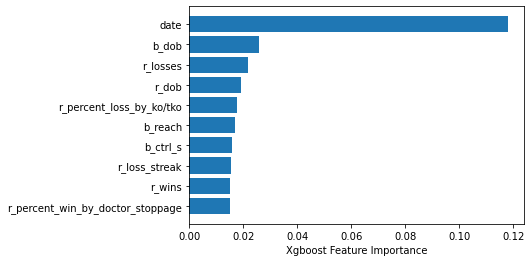

In [18]:
clf = XGBClassifier(learning_rate=0.05, n_estimators=114, max_depth=5, min_child_weight=5, gamma=0.6,
                          colsample_bytree= 0.9, subsample = 1,
                          reg_alpha=0.00001, reg_lambda=1, random_state=1, n_jobs=-1)
clf.fit(X, y)
sorted_idx = clf.feature_importances_.argsort()[-10:]
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

# II. Model Testing on Data With No Missing Values

Create explanatory and response variables.

In [2]:
df = pd.read_csv('train_no_na.csv')
X = df.drop(['outcome'], axis=1)
y = pd.get_dummies(df['outcome'], drop_first=True)

Identify numeric and categorical columns.

In [3]:
numeric_columns = X.select_dtypes(include=['number']).columns

categorical_columns = list(set(X.columns) - set(numeric_columns))

Preprocess data. Need column names for importance so do transformations seperately and join dfs after.

In [4]:
numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
categorical_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('ohe', OneHotEncoder(sparse=False))])

num_X = pd.DataFrame(numeric_pipe.fit_transform(X[numeric_columns]), columns=numeric_columns)

cat_X = categorical_pipe.fit_transform(X[categorical_columns])
onehot_col_names = categorical_pipe.named_steps['ohe'].get_feature_names_out(input_features=categorical_columns)
cat_X = pd.DataFrame(cat_X, columns=onehot_col_names)

X = pd.merge(num_X, cat_X, left_index=True, right_index=True)

y = np.ravel(y).reshape((-1,))

X.head()

,r_kd,r_sub.att,r_rev.,r_ctrl_s,r_sig_str_percent,r_sig_str_att,r_total_str_percent,r_total_str_att,r_td_percent,r_td_att,...,b_stance_Orthodox,b_stance_Southpaw,b_stance_Switch,title_False,title_True,r_stance_--,r_stance_Open Stance,r_stance_Orthodox,r_stance_Southpaw,r_stance_Switch
0,0.222222,0.222222,0.000000,100.444444,0.410538,202.444444,0.431990,213.611111,0.642857,1.555556,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.166667,0.000000,0.000000,195.666667,0.426600,132.833333,0.514486,166.833333,0.280000,4.166667,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.571429,0.285714,0.214286,132.500000,0.502677,106.714286,0.545293,120.642857,0.500000,2.714286,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.333333,0.222222,0.111111,123.111111,0.390576,106.111111,0.497585,138.000000,0.428571,0.777778,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.000000,0.000000,0.000000,47.000000,0.693878,49.000000,0.716981,53.000000,0.250000,4.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# XGBoost

## Randomized Search
Tune model parameters and obtain cv accuracy estimates.

In [5]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(random_state=1, n_jobs=-1)
distributions1 = dict(learning_rate = [0.05, 0.1, 0.15],
                      n_estimators = [50, 100, 150],
                      max_depth = range(2,10),
                      min_child_weight = range(1,10))
random1 = RandomizedSearchCV(estimator=clf, param_distributions=distributions1,
                            scoring='neg_log_loss', n_iter=10, cv=rkf, random_state=1) # TODO Does changing the seed here only change the parameter grid? If so can I change it to obtain better results? Yes
random1.fit(X, y)
print("Highest neg_log_loss: ", random1.best_score_)
print("Best parameters: ", random1.best_params_)

Highest neg_log_loss:  -0.5831215666655719
Best parameters:  {'n_estimators': 150, 'min_child_weight': 9, 'max_depth': 2, 'learning_rate': 0.1}


In [6]:
random_table1 = pd.concat([pd.DataFrame(random1.cv_results_["params"]),
                          pd.DataFrame(random1.cv_results_["mean_test_score"],
                                       columns=["Negative Log Loss"])],axis=1)
random_table1.sort_values("Negative Log Loss", ascending=False)

,n_estimators,min_child_weight,max_depth,learning_rate,Negative Log Loss
1,150,9,2,0.10,-0.583122
4,50,6,3,0.15,-0.583210
2,50,3,3,0.15,-0.583595
0,150,3,2,0.15,-0.585247
8,150,3,6,0.05,-0.590780
6,100,9,9,0.05,-0.592079
5,150,2,3,0.15,-0.594686
3,150,8,6,0.10,-0.610000
9,50,5,9,0.15,-0.616927
7,150,1,8,0.10,-0.644530


Recalibrate n_estimators

In [7]:
xgb_param = XGBClassifier(learning_rate=0.1, max_depth=2, min_child_weight=9, random_state=1, n_jobs=-1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

108
0      0.678961
1      0.667322
2      0.657695
3      0.649423
4      0.642408
         ...   
103    0.581429
104    0.581499
105    0.581358
106    0.581396
107    0.581223
Name: test-logloss-mean, Length: 108, dtype: float64


In [8]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.1, n_estimators=108, max_depth=2, min_child_weight=9, random_state=1, n_jobs=-1)
distributions2 = dict(gamma=np.arange(0,1.1,0.2),
                      subsample = np.arange(0.5, 1.0, 0.1),
                      colsample_bytree = np.arange(0.4, 1.0, 0.1),
                      reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],
                      reg_lambda=[1e-5, 1e-2, 0.1, 1, 100])
random2 = RandomizedSearchCV(estimator=clf, param_distributions=distributions2,
                            scoring='neg_log_loss', n_iter=10, cv=rkf, random_state=33)
random2.fit(X, y)
print("Highest neg_log_loss: ", random2.best_score_)
print("Best parameters: ", random2.best_params_)

Highest neg_log_loss:  -0.5824535899492106
Best parameters:  {'subsample': 0.8999999999999999, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}


In [9]:
random_table2 = pd.concat([pd.DataFrame(random2.cv_results_["params"]),
                          pd.DataFrame(random2.cv_results_["mean_test_score"],
                                       columns=["Negative Log Loss"])],axis=1)
random_table2.sort_values("Negative Log Loss", ascending=False)

,subsample,reg_lambda,reg_alpha,gamma,colsample_bytree,Negative Log Loss
0,0.9,0.10000,0.10000,0.2,0.7,-0.582454
9,0.9,1.00000,0.01000,0.8,0.6,-0.582616
1,0.8,0.00001,1.00000,0.8,0.4,-0.582904
4,0.7,0.01000,0.10000,0.0,0.4,-0.583517
2,0.6,0.01000,1.00000,0.6,0.7,-0.584471
3,0.8,100.00000,0.00001,0.4,0.8,-0.587599
7,0.9,0.01000,100.00000,0.8,0.6,-0.622843
5,0.8,1.00000,100.00000,1.0,0.6,-0.627969
6,0.7,0.00001,100.00000,0.0,0.4,-0.632881
8,0.7,100.00000,100.00000,0.2,0.6,-0.634410


## Regular Grid Search
Tune model parameters and obtain cv accuracy estimates.

For learning rates, determine the optimum n_estimators, and corresponding accuracy.

In [10]:
for i in np.arange(0.05, 0.35, 0.05):
    xgb_param = XGBClassifier(learning_rate=i, random_state=1).get_xgb_params()
    xg = xgb.DMatrix(X.values, label=y)
    cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                      metrics='logloss', early_stopping_rounds=100, seed=1)
    print(cvresult.shape[0])
    print(cvresult['test-logloss-mean'])

84
0     0.684534
1     0.676770
2     0.669895
3     0.663391
4     0.657521
        ...   
79    0.583512
80    0.583542
81    0.583601
82    0.583528
83    0.583502
Name: test-logloss-mean, Length: 84, dtype: float64
31
0     0.676493
1     0.662769
2     0.651973
3     0.642601
4     0.634399
5     0.627823
6     0.621971
7     0.617073
8     0.612771
9     0.609694
10    0.606367
11    0.604046
12    0.601513
13    0.599488
14    0.597298
15    0.595677
16    0.594502
17    0.593262
18    0.591874
19    0.590761
20    0.590040
21    0.589314
22    0.588637
23    0.588124
24    0.588079
25    0.587761
26    0.587790
27    0.587418
28    0.586802
29    0.586624
30    0.585953
Name: test-logloss-mean, dtype: float64
29
0     0.669020
1     0.651159
2     0.637765
3     0.627960
4     0.620367
5     0.614321
6     0.609839
7     0.605165
8     0.601933
9     0.599268
10    0.597569
11    0.595719
12    0.594916
13    0.593943
14    0.592441
15    0.592044
16    0.591527
17    0.591134

Tune max_depth and min_child_weight

In [11]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=84, random_state=1, n_jobs=-1)
param_grid1 = dict(max_depth=range(2,10,2),
                   min_child_weight=range(1,10,2))
grid1 = GridSearchCV(estimator=clf, param_grid=param_grid1, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid1.fit(X, y)
print("Highest neg_log_loss: ", grid1.best_score_)
print("Best parameters:", grid1.best_params_)

Highest neg_log_loss:  -0.5829768493991795
Best parameters: {'max_depth': 4, 'min_child_weight': 5}


In [12]:
grid1_table = pd.concat([pd.DataFrame(grid1.cv_results_['params']),
                         pd.DataFrame(grid1.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid1_table.sort_values('Negative Log Loss', ascending=False)

,max_depth,min_child_weight,Negative Log Loss
7,4,5,-0.582977
5,4,1,-0.583078
9,4,9,-0.583133
6,4,3,-0.583145
8,4,7,-0.583377
12,6,5,-0.585131
14,6,9,-0.585179
11,6,3,-0.585325
13,6,7,-0.585403
10,6,1,-0.586336


More fine tuning around optimal params from previous step

In [13]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=84, random_state=1, n_jobs=-1)
param_grid2 = dict(max_depth=[3,4,5],
                   min_child_weight=[4,5,6])
grid2 = GridSearchCV(estimator=clf, param_grid=param_grid2, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid2.fit(X, y)
print("Highest neg_log_loss: ", grid2.best_score_)
print("Best parameters:", grid2.best_params_)

Highest neg_log_loss:  -0.5829457490873171
Best parameters: {'max_depth': 4, 'min_child_weight': 6}


In [17]:
grid2_table = pd.concat([pd.DataFrame(grid2.cv_results_['params']),
                         pd.DataFrame(grid2.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid2_table.sort_values('Negative Log Loss', ascending=False)

,max_depth,min_child_weight,Negative Log Loss
5,4,6,-0.582946
4,4,5,-0.582977
3,4,4,-0.583014
0,3,4,-0.583412
2,3,6,-0.583438
1,3,5,-0.583495
7,5,5,-0.583909
8,5,6,-0.584027
6,5,4,-0.584031


Recalibrate n_estimators

In [14]:
xgb_param = XGBClassifier(learning_rate=0.05, max_depth=5, min_child_weight=3, random_state=1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

84
0     0.684642
1     0.677033
2     0.669989
3     0.663824
4     0.657944
        ...   
79    0.582279
80    0.582285
81    0.582312
82    0.582256
83    0.582156
Name: test-logloss-mean, Length: 84, dtype: float64


Tune gamma.

In [15]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=84, max_depth=5, min_child_weight=3, random_state=1, n_jobs=-1)
param_grid3 = dict(gamma=np.arange(0,1,0.2))
grid3 = GridSearchCV(estimator=clf, param_grid=param_grid3, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid3.fit(X, y)
print("Highest neg_log_loss: ", grid3.best_score_)
print("Best parameters:", grid3.best_params_)

Highest neg_log_loss:  -0.5839221716242529
Best parameters: {'gamma': 0.2}


In [16]:
grid3_table = pd.concat([pd.DataFrame(grid3.cv_results_['params']),
                         pd.DataFrame(grid3.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid3_table.sort_values('Negative Log Loss', ascending=False)

,gamma,Negative Log Loss
1,0.2,-0.583922
0,0.0,-0.583930
4,0.8,-0.584064
3,0.6,-0.584099
2,0.4,-0.584186


Recalibrate n_estimators.

In [18]:
xgb_param = XGBClassifier(learning_rate=0.05, max_depth=5, min_child_weight=3, gamma=0.2, random_state=1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(1-cvresult['test-logloss-mean'])

77
0     0.315358
1     0.322967
2     0.330011
3     0.336176
4     0.342056
        ...   
72    0.417394
73    0.417541
74    0.417694
75    0.417724
76    0.417785
Name: test-logloss-mean, Length: 77, dtype: float64


Tune subsample and colsample_bytree.

In [20]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=77,  max_depth=5, min_child_weight=3, gamma=0.2, random_state=1, n_jobs=-1)
param_grid4 = dict(subsample=[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   colsample_bytree=[0.5, 0.6, 0.7, 0.8, 0.9, 1])
grid4 = GridSearchCV(estimator=clf, param_grid=param_grid4, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid4.fit(X, y)
print("Highest neg_log_loss: ", grid4.best_score_)
print("Best parameters:", grid4.best_params_)

Highest neg_log_loss:  -0.583501041527509
Best parameters: {'colsample_bytree': 1, 'subsample': 0.9}


In [21]:
grid4_table = pd.concat([pd.DataFrame(grid4.cv_results_['params']),
                         pd.DataFrame(grid4.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid4_table.sort_values('Negative Log Loss', ascending=False)

,colsample_bytree,subsample,Negative Log Loss
34,1.0,0.9,-0.583501
28,0.9,0.9,-0.583600
27,0.9,0.8,-0.583652
33,1.0,0.8,-0.583660
32,1.0,0.7,-0.584075
35,1.0,1.0,-0.584183
22,0.8,0.9,-0.584402
26,0.9,0.7,-0.584552
29,0.9,1.0,-0.584643
23,0.8,1.0,-0.584660


Tune regularization parameters.

In [22]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.05, n_estimators=77,  max_depth=5, min_child_weight=3, gamma=0.2,
                    colsample_bytree=1, subsample=0.9,
                    random_state=1, n_jobs=-1)
param_grid5 = dict(reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],
                   reg_lambda=[1e-5, 1e-2, 0.1, 1, 100])
grid5 = GridSearchCV(estimator=clf, param_grid=param_grid5, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
grid5.fit(X, y)
print("Highest neg_log_loss: ", grid5.best_score_)
print("Best parameters:", grid5.best_params_)

Highest neg_log_loss:  -0.5832891491066186
Best parameters: {'reg_alpha': 1e-05, 'reg_lambda': 0.1}


In [23]:
grid5_table = pd.concat([pd.DataFrame(grid5.cv_results_['params']),
                         pd.DataFrame(grid5.cv_results_['mean_test_score'],
                                      columns=['Negative Log Loss'])],axis=1)

grid5_table.sort_values('Negative Log Loss', ascending=False)

,reg_alpha,reg_lambda,Negative Log Loss
2,0.00001,0.10000,-0.583289
1,0.00001,0.01000,-0.583443
3,0.00001,1.00000,-0.583493
7,0.01000,0.10000,-0.583511
5,0.01000,0.00001,-0.583569
12,0.10000,0.10000,-0.583600
6,0.01000,0.01000,-0.583657
11,0.10000,0.01000,-0.583732
0,0.00001,0.00001,-0.583756
15,1.00000,0.00001,-0.583776


Try lowering the learning rate and adjusting n_estimators

In [25]:
import xgboost as xgb

xgb_param = XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=3, gamma=0.2,
                          colsample_bytree=1, subsample=0.9, reg_alpha=0.00001, reg_lambda=0.1,
                          random_state=1, n_jobs=-1).get_xgb_params()
xg = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xg, num_boost_round=1000, nfold=5,
                  metrics='logloss', early_stopping_rounds=100, seed=1)
print(cvresult.shape[0])
print(cvresult['test-logloss-mean'])

481
0      0.691428
1      0.689672
2      0.687981
3      0.686313
4      0.684728
         ...   
476    0.580230
477    0.580229
478    0.580243
479    0.580256
480    0.580228
Name: test-logloss-mean, Length: 481, dtype: float64


In [26]:
rkf = RepeatedKFold(random_state=1)

clf = XGBClassifier(learning_rate=0.01, n_estimators=481, max_depth=5, min_child_weight=3, gamma=0.2,
                    colsample_bytree=1, subsample=0.9, reg_alpha=0.00001, reg_lambda=0.1,
                    random_state=1, n_jobs=-1)
cv_scores = cross_val_score(estimator=clf, X=X, y=y, scoring='neg_log_loss', cv=rkf, n_jobs=-1)
print(mean(cv_scores))

-0.582121891248411


# Feature Importances

Text(0.5, 0, 'Xgboost Feature Importance')

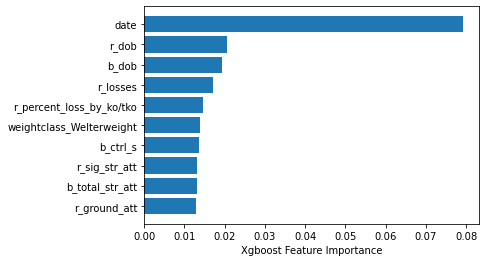

In [27]:
clf = XGBClassifier(learning_rate=0.01, n_estimators=481, max_depth=5, min_child_weight=3, gamma=0.2,
                    colsample_bytree=1, subsample=0.9, reg_alpha=0.00001, reg_lambda=0.1,
                    random_state=1, n_jobs=-1)
clf.fit(X, y)
sorted_idx = clf.feature_importances_.argsort()[-10:]
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")